# 네이버 영화리뷰 감성분석

In [1]:
# 먼저 프로젝트를 진행하기 전에 몇가지 작업이 필요하다. wget으로 데이터를 받아오고 작업할 폴더에 저장해준다.
# $ wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
# $ wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt
# $ mv ratings_*.txt ~/aiffel/sentiment_classification

## 1. 데이터 준비와 확인

In [1]:
# 필요한 모듈을 import한다
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어온다
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

## 2. 데이터로더 구성

In [2]:
# 실습 때 다루었던 IMDB 데이터셋은 이미 가공되어 있었고 imdb.data_loader()함수를 호출하여 여러가지 작업을 할 수 있었다.
# 그러나 이번 데이터셋은 가공되어 있지 않으므로 imdb.data.loader()와 동일하게 동작하는 data_loader 함수를 하나 만들어줘야 한다.

from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [3]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [4]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수
# 단, 모든 문장은 <BOS>로 시작하는 것으로 한다
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 3. 모델구성을 위한 데이터 분석 및 가공

In [5]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96938143432699
문장길이 최대 :  116
문장길이 표준편차 :  12.843571939469296
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


## 4. 모델구성 및 validation set 구성

In [6]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)
print(X_train.shape)

(146182, 41)


In [7]:
# validation set 50000개 분리
X_val = X_train[:50000]   
y_val = y_train[:50000]

partial_X_train = X_train[50000:]  
partial_y_train = y_train[50000:]

print(X_train.shape)
print(partial_X_train.shape)
print(partial_y_train.shape)

(146182, 41)
(96182, 41)
(96182,)


In [8]:
vocab_size = 10000    # 어휘 사전의 크기 (10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 1-D CNN

In [9]:
# model 설계
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 2개의 값

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 200)         2000000   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          22416     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9

## 모델 훈련 개시

In [10]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=15

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/15
188/188 [==============================] - 9s 50ms/step - loss: 0.4743 - accuracy: 0.7597 - val_loss: 0.3548 - val_accuracy: 0.8462
Epoch 2/15
188/188 [==============================] - 9s 50ms/step - loss: 0.3174 - accuracy: 0.8669 - val_loss: 0.3378 - val_accuracy: 0.8531
Epoch 3/15
188/188 [==============================] - 9s 49ms/step - loss: 0.2649 - accuracy: 0.8929 - val_loss: 0.3440 - val_accuracy: 0.8531
Epoch 4/15
188/188 [==============================] - 9s 49ms/step - loss: 0.2069 - accuracy: 0.9214 - val_loss: 0.3753 - val_accuracy: 0.8454
Epoch 5/15
188/188 [==============================] - 9s 49ms/step - loss: 0.1483 - accuracy: 0.9476 - val_loss: 0.4232 - val_accuracy: 0.8383
Epoch 6/15
188/188 [==============================] - 9s 49ms/step - loss: 0.1012 - accuracy: 0.9666 - val_loss: 0.4873 - val_accuracy: 0.8397
Epoch 7/15
188/188 [==============================] - 9s 49ms/step - loss: 0.0707 - accuracy: 0.9776 - val_loss: 0.5760 - val_accuracy: 0.8364

In [11]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 1s - loss: 1.0454 - accuracy: 0.8200
[1.0453839302062988, 0.8199849724769592]


## 6. Loss, Accuracy 그래프 시각화

In [12]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


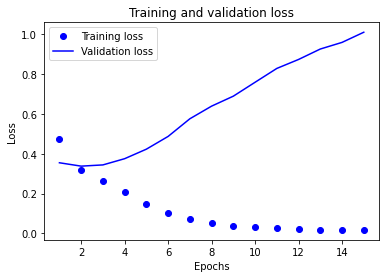

In [13]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

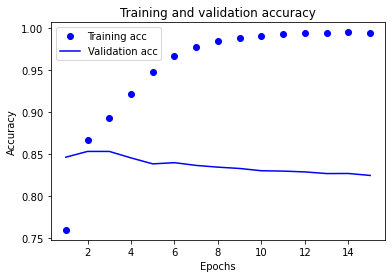

In [14]:
plt.clf()   # 그림을 초기화한다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 7. 같은 방법으로 여러가지 모델을 만들고 결과를 시각화 해보자

### 7.1 GlobalMaxPooling

In [15]:
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(keras.layers.GlobalMaxPooling1D())
model2.add(keras.layers.Dense(8, activation='relu'))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 1608      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 2,001,617
Trainable params: 2,001,617
Non-trainable params: 0
_________________________________________________________________


In [16]:
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=15

history = model2.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/15
188/188 [==============================] - 5s 24ms/step - loss: 0.5030 - accuracy: 0.7994 - val_loss: 0.3610 - val_accuracy: 0.8431
Epoch 2/15
188/188 [==============================] - 4s 24ms/step - loss: 0.3234 - accuracy: 0.8627 - val_loss: 0.3383 - val_accuracy: 0.8519
Epoch 3/15
188/188 [==============================] - 4s 23ms/step - loss: 0.2720 - accuracy: 0.8883 - val_loss: 0.3419 - val_accuracy: 0.8523
Epoch 4/15
188/188 [==============================] - 5s 24ms/step - loss: 0.2309 - accuracy: 0.9095 - val_loss: 0.3540 - val_accuracy: 0.8508
Epoch 5/15
188/188 [==============================] - 5s 25ms/step - loss: 0.1920 - accuracy: 0.9280 - val_loss: 0.3717 - val_accuracy: 0.8502
Epoch 6/15
188/188 [==============================] - 5s 25ms/step - loss: 0.1530 - accuracy: 0.9473 - val_loss: 0.4011 - val_accuracy: 0.8468
Epoch 7/15
188/188 [==============================] - 5s 25ms/step - loss: 0.1170 - accuracy: 0.9634 - val_loss: 0.4390 - val_accuracy: 0.8448

In [17]:
results = model2.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 1s - loss: 0.7327 - accuracy: 0.8329
[0.7327057123184204, 0.832902729511261]


In [18]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


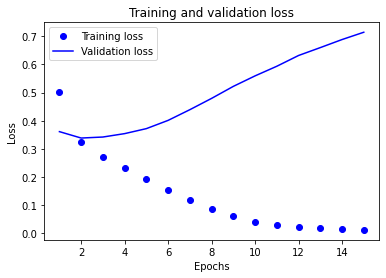

In [19]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

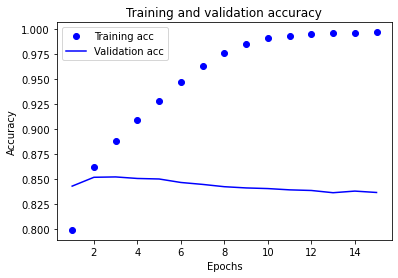

In [20]:
plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 7.2 LSTM

In [21]:
model3 = keras.Sequential()
model3.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model3.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용했다. 이때 LSTM state 벡터의 차원수는 8로 설정해봤다,
model3.add(keras.layers.Dense(8, activation='relu'))
model3.add(keras.layers.Dense(1, activation='sigmoid')).

model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 6688      
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
_________________________________________________________________


In [22]:
model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=15

history = model3.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/15
188/188 [==============================] - 9s 50ms/step - loss: 0.5463 - accuracy: 0.7201 - val_loss: 0.4137 - val_accuracy: 0.8291
Epoch 2/15
188/188 [==============================] - 9s 50ms/step - loss: 0.3620 - accuracy: 0.8500 - val_loss: 0.3586 - val_accuracy: 0.8406
Epoch 3/15
188/188 [==============================] - 9s 49ms/step - loss: 0.3127 - accuracy: 0.8713 - val_loss: 0.3552 - val_accuracy: 0.8418
Epoch 4/15
188/188 [==============================] - 9s 50ms/step - loss: 0.2864 - accuracy: 0.8816 - val_loss: 0.3568 - val_accuracy: 0.8505
Epoch 5/15
188/188 [==============================] - 9s 48ms/step - loss: 0.2627 - accuracy: 0.8910 - val_loss: 0.3567 - val_accuracy: 0.8509
Epoch 6/15
188/188 [==============================] - 9s 48ms/step - loss: 0.2425 - accuracy: 0.8992 - val_loss: 0.3925 - val_accuracy: 0.8508
Epoch 7/15
188/188 [==============================] - 9s 48ms/step - loss: 0.2214 - accuracy: 0.9076 - val_loss: 0.3893 - val_accuracy: 0.8505

In [23]:
results = model3.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.5487 - accuracy: 0.8373
[0.5487481355667114, 0.837256133556366]


In [24]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


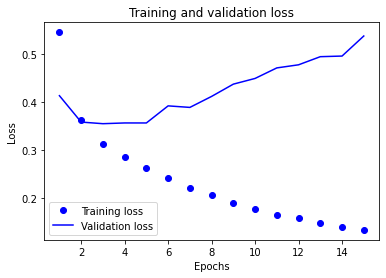

In [25]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

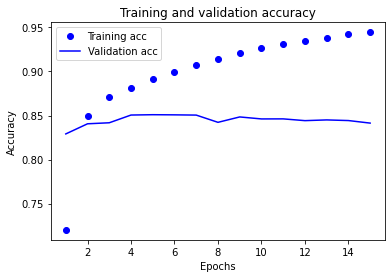

In [26]:
plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [27]:
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)

results = model2.evaluate(X_test,  y_test, verbose=2)
print(results)

results = model3.evaluate(X_test,  y_test, verbose=2)
print(results)

1537/1537 - 1s - loss: 1.0454 - accuracy: 0.8200
[1.0453839302062988, 0.8199849724769592]
1537/1537 - 1s - loss: 0.7327 - accuracy: 0.8329
[0.7327057123184204, 0.832902729511261]
1537/1537 - 3s - loss: 0.5487 - accuracy: 0.8373
[0.5487481355667114, 0.837256133556366]


## 8. Embedding 레이어 분석

In [28]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 200)


In [29]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim)) # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀 작성

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [30]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['컴퓨터']
vector

array([ 0.06952369, -0.02578371,  0.06196725,  0.00986905,  0.01474463,
       -0.02072764,  0.02303465, -0.01791039,  0.00188091,  0.05199382,
       -0.06593703,  0.00288688, -0.02498547,  0.03044376, -0.03575508,
        0.01378188,  0.03854604, -0.01515799,  0.03381435,  0.00262449,
       -0.01518493, -0.05799035, -0.01557747,  0.03642656, -0.03755179,
        0.01858604, -0.04681688,  0.05630844, -0.04654307, -0.03025717,
       -0.07999539,  0.06067616,  0.00840516,  0.03764023, -0.07904806,
        0.00639771, -0.01092664,  0.02532963,  0.00588944,  0.01915316,
       -0.05140981,  0.03155543,  0.03355894,  0.02204916, -0.01892888,
       -0.02551072, -0.00825428,  0.04440306,  0.00108901, -0.00788196,
        0.04261127, -0.04105977,  0.0591436 , -0.05782986, -0.01199975,
       -0.00065827,  0.01439163, -0.00387915, -0.01303597, -0.00405741,
        0.00708544,  0.04516433,  0.00363574,  0.00782371,  0.02367463,
        0.01937493, -0.03395503,  0.00397594, -0.02935283, -0.02

In [31]:
word_vectors.similar_by_word("컴퓨터")

[('재일', 0.3526926040649414),
 ('장진영', 0.3259234130382538),
 ('추적', 0.3246484398841858),
 ('부럽', 0.3089445233345032),
 ('으리', 0.3067253828048706),
 ('인상', 0.29819634556770325),
 ('경찰', 0.2963793873786926),
 ('차별', 0.2958981394767761),
 ('이라도', 0.28912079334259033),
 ('엑', 0.28670597076416016)]

## 9. Word2Vec을 사용한 분석

In [32]:
# https://github.com/Kyubyong/wordvectors 에서 한국어 Word2Vec 파일을 받아온다
# 작업폴더를 만들고 풀어준다
# 데이터를 불러온다
import os
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko/ko.bin'

In [33]:
import gensim
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
word2vec = Word2Vec.load(word2vec_file_path)

In [34]:
# "컴퓨터"라는 단어와 가장 가까운 단어를 알아보자(메모리를 다소 많이 소비하는 작업이니 유의해야 됨)
word2vec.similar_by_word("컴퓨터")

/home/ssac3/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  


[('하드웨어', 0.7727355360984802),
 ('소프트웨어', 0.7308895587921143),
 ('마이크로프로세서', 0.7205492258071899),
 ('개인용', 0.7154535055160522),
 ('노트북', 0.7130324244499207),
 ('계산기', 0.7044994831085205),
 ('하드디스크', 0.6943572759628296),
 ('태블릿', 0.6915029287338257),
 ('그래픽스', 0.6882646679878235),
 ('프린터', 0.6876466274261475)]

In [35]:
# 학습했던 모델의 임베딩 레이어를 지금 받은 W2V로 교체하기 위한 작업

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/home/ssac3/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  # Remove the CWD from sys.path while we load stuff.
/home/ssac3/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


## 9.1 W2V를 적용한 모델을 만들어 보고 학습 시킨다

### 9.1.1 1D-CNN

In [37]:
from tensorflow.keras.initializers import Constant

# 모델 구성
model4 = keras.Sequential()
model4.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))
model4.add(keras.layers.Conv1D(16, 7, activation='relu'))
model4.add(keras.layers.MaxPooling1D(5))
model4.add(keras.layers.Conv1D(16, 7, activation='relu'))
model4.add(keras.layers.GlobalMaxPooling1D())
model4.add(keras.layers.Dense(8, activation='relu'))
model4.add(keras.layers.Dense(1, activation='sigmoid')) 

model4.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 35, 16)            22416     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [39]:
# 학습
model4.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5

history = model4.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/5
188/188 [==============================] - 10s 51ms/step - loss: 0.3004 - accuracy: 0.8743 - val_loss: 0.3653 - val_accuracy: 0.8409
Epoch 2/5
188/188 [==============================] - 9s 50ms/step - loss: 0.2714 - accuracy: 0.8893 - val_loss: 0.3694 - val_accuracy: 0.8419
Epoch 3/5
188/188 [==============================] - 9s 50ms/step - loss: 0.2490 - accuracy: 0.8999 - val_loss: 0.3742 - val_accuracy: 0.8428
Epoch 4/5
188/188 [==============================] - 9s 50ms/step - loss: 0.2268 - accuracy: 0.9119 - val_loss: 0.3932 - val_accuracy: 0.8372
Epoch 5/5
188/188 [==============================] - 9s 50ms/step - loss: 0.2043 - accuracy: 0.9212 - val_loss: 0.4195 - val_accuracy: 0.8366


In [40]:
# 테스트셋을 통한 모델 평가
results = model4.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 1s - loss: 0.4380 - accuracy: 0.8330
[0.43799537420272827, 0.8329840898513794]


### 9.1.2 LSTM

In [41]:
from tensorflow.keras.initializers import Constant

# 모델 구성
model5 = keras.Sequential()
model5.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))
model5.add(keras.layers.LSTM(96))
model5.add(keras.layers.Dense(8, activation='relu'))
model5.add(keras.layers.Dense(1, activation='sigmoid'))

model5.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 96)                114048    
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 776       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 2,114,833
Trainable params: 2,114,833
Non-trainable params: 0
_________________________________________________________________


In [42]:
# 학습
model5.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5

history = model5.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/5
188/188 [==============================] - 26s 139ms/step - loss: 0.5992 - accuracy: 0.6361 - val_loss: 0.4274 - val_accuracy: 0.8100
Epoch 2/5
188/188 [==============================] - 25s 134ms/step - loss: 0.3742 - accuracy: 0.8351 - val_loss: 0.3466 - val_accuracy: 0.8497
Epoch 3/5
188/188 [==============================] - 23s 120ms/step - loss: 0.3105 - accuracy: 0.8681 - val_loss: 0.3367 - val_accuracy: 0.8547
Epoch 4/5
188/188 [==============================] - 23s 124ms/step - loss: 0.2748 - accuracy: 0.8855 - val_loss: 0.3328 - val_accuracy: 0.8590
Epoch 5/5
188/188 [==============================] - 23s 121ms/step - loss: 0.2488 - accuracy: 0.8989 - val_loss: 0.3421 - val_accuracy: 0.8594


### 9.1.3 W2V GMP

In [43]:
# 모델 구성
model6 = keras.Sequential()
model6.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))
model6.add(keras.layers.GlobalMaxPooling1D())
model6.add(keras.layers.Dense(8, activation='relu'))
model6.add(keras.layers.Dense(1, activation='sigmoid'))

model6.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 200)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 1608      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 9         
Total params: 2,001,617
Trainable params: 2,001,617
Non-trainable params: 0
_________________________________________________________________


In [44]:
# 학습
model6.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5

history = model6.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/5
188/188 [==============================] - 4s 23ms/step - loss: 0.6795 - accuracy: 0.5668 - val_loss: 0.6297 - val_accuracy: 0.6444
Epoch 2/5
188/188 [==============================] - 4s 23ms/step - loss: 0.5773 - accuracy: 0.6967 - val_loss: 0.5389 - val_accuracy: 0.7292
Epoch 3/5
188/188 [==============================] - 4s 24ms/step - loss: 0.5150 - accuracy: 0.7476 - val_loss: 0.4994 - val_accuracy: 0.7571
Epoch 4/5
188/188 [==============================] - 4s 24ms/step - loss: 0.4746 - accuracy: 0.7749 - val_loss: 0.4724 - val_accuracy: 0.7742
Epoch 5/5
188/188 [==============================] - 4s 24ms/step - loss: 0.4446 - accuracy: 0.7938 - val_loss: 0.4535 - val_accuracy: 0.7840


In [45]:
# 1D-CNN
results = model.evaluate(X_test,  y_test, verbose=2)
print(results)
# GMP
results = model2.evaluate(X_test,  y_test, verbose=2)
print(results)
# LSTM
results = model3.evaluate(X_test,  y_test, verbose=2)
print(results)
# W2V 1D CNN
results = model4.evaluate(X_test,  y_test, verbose=2)
print(results)
# W2V LSTM
results = model5.evaluate(X_test,  y_test, verbose=2)
print(results)
# W2V GMP
results = model6.evaluate(X_test,  y_test, verbose=2)
print(results)

1537/1537 - 1s - loss: 1.0454 - accuracy: 0.8200
[1.0453839302062988, 0.8199849724769592]
1537/1537 - 1s - loss: 0.7327 - accuracy: 0.8329
[0.7327057123184204, 0.832902729511261]
1537/1537 - 3s - loss: 0.5487 - accuracy: 0.8373
[0.5487481355667114, 0.837256133556366]
1537/1537 - 1s - loss: 0.4380 - accuracy: 0.8330
[0.43799537420272827, 0.8329840898513794]
1537/1537 - 8s - loss: 0.3504 - accuracy: 0.8548
[0.3504128158092499, 0.8547714352607727]
1537/1537 - 1s - loss: 0.4603 - accuracy: 0.7803
[0.4602537453174591, 0.7803364992141724]
